# Driving Repeat Business in the Brazilian E-Commerce Market

One of the most important tenets of retail growth is repeat business: if your customers leave your store each time pleased with the service and products, the probability of them returning in the near future (as well as friends and family they speak to regularly) skyrockets. Consequently, it is crucial for business analytics teams to determine what drives repeat customers, and to what effect customer satisfaction affects profits. 

By inspecting clusters of customers defined by their purchase frequency and overall value, analysts may discover trends in the purchasing habits of more frequent and valuable customers to more effectively target customers at each level and create more successful marketing campaigns to convert more one time customers into repeat patrons.

The dataset was provided by OList, a Brazilian Ecommerce website, detailing 100k+ purchases made by real customers, while their identities and personal information have been classified. Link below:

 https://www.kaggle.com/olistbr/brazilian-ecommerce

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import geopy.distance
import jenkspy
import seaborn as sns
from numpy.random import random_sample
import matplotlib.patches as mpatches
from scipy.stats import boxcox
from scipy.stats import normaltest
from scipy.spatial.distance import pdist, cdist
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

The dataset is stored in 9 CSV files, which will be merged by each primary key to get the logistics, price, and review information per purchase. 

In [2]:
#E-Commerce CSVs
customers = pd.read_csv('olist_customers_dataset.csv')
geoloc = pd.read_csv('olist_geolocation_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')  
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders =  pd.read_csv('olist_orders_dataset.csv') 
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
translations =  pd.read_csv('product_category_name_translation.csv')

In [3]:
#Merge translations & drop Portuguese names
products_translated =  products.merge(
    translations, how = 'left', 
    on = 'product_category_name').drop(
    columns = 'product_category_name')

In [4]:
#Use only payment info for unique orders
grouped_payments = payments.groupby('order_id').sum()

In [5]:
#Filter geolocations down to zip code centroids
grouped_locs = geoloc.groupby('geolocation_zip_code_prefix').mean()

In [6]:
#This merge contains each unique customer, order,
#How many payments, and total payment value
customer_orders =  customers.merge(
    orders, how = 'left', on = 'customer_id').merge(
    reviews, how = 'left', on = 'order_id').merge(
    grouped_payments, how = 'left', on = 'order_id')

In [7]:
#Combine products, sellers, & items
seller_items =  items.merge(
    sellers, how = 'left', on = 'seller_id').merge(
    products_translated, how = 'left', on = 'product_id').merge(
    grouped_locs, how = 'left', left_on = 'seller_zip_code_prefix',
    right_on = 'geolocation_zip_code_prefix')

In [8]:
#Merge 3 conglomerates w/o duplicate orders/customer ids
all_data = customer_orders.merge(
    seller_items, how = 'left', on = 'order_id').merge(
    grouped_locs, how = 'left', suffixes = ['_customer', '_seller'], 
    left_on = 'customer_zip_code_prefix', 
    right_on = 'geolocation_zip_code_prefix')

In [9]:
#Clean columns and inspect new DF
all_data = all_data.rename(
    columns = {'product_name_lenght': 'product_name_length', 
             'product_description_lenght': 'product_description_length'})

In [10]:
#Define rows missing lats/longs
no_coords =  all_data[pd.isnull(all_data.geolocation_lat_customer)]
no_coords_sellers =  all_data[pd.isnull(all_data.geolocation_lat_seller)]

In [11]:
all_data.describe()

,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,seller_zip_code_prefix,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat_customer,geolocation_lng_customer,geolocation_lat_seller,geolocation_lng_seller
count,114100.000000,114100.000000,114097.000000,114097.000000,114097.000000,113322.000000,113322.000000,113322.000000,113322.000000,111710.000000,111710.000000,111710.000000,113304.000000,113304.000000,113304.000000,113304.000000,113065.000000,113065.000000,113789.000000,113789.000000
mean,35105.746450,3.999816,1.143194,3.071641,180.382566,1.198514,120.481328,19.979641,24441.493338,48.777459,786.881040,2.206857,2091.970831,30.162210,16.584816,23.003645,-22.798343,-47.238097,-21.238151,-46.204339
std,29868.322786,1.412251,2.880956,2.834690,273.059700,0.706993,183.277636,15.782926,27597.074698,10.024601,651.745733,1.719464,3749.785242,16.151345,13.439402,11.708565,2.693465,2.339006,5.565034,4.035352
min,1003.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.850000,0.000000,1001.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,-32.079231,-67.813284,-33.689948,-72.668881
25%,11250.000000,3.000000,1.000000,1.000000,65.630000,1.000000,39.900000,13.080000,6429.000000,42.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000,-23.607473,-48.829744,-23.591282,-48.109940
50%,24320.000000,5.000000,1.000000,2.000000,114.330000,1.000000,74.900000,16.260000,13568.000000,52.000000,601.000000,1.000000,700.000000,25.000000,13.000000,20.000000,-23.425556,-46.744092,-22.930174,-46.634203
75%,59022.000000,5.000000,1.000000,4.000000,195.390000,1.000000,134.900000,21.150000,27930.000000,57.000000,985.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,-21.757321,-46.518679,-20.179524,-43.651694
max,99990.000000,5.000000,435.000000,29.000000,13664.080000,21.000000,6735.000000,409.680000,99730.000000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,-2.501242,-34.855616,42.184003,-8.723762


In [12]:
#Replace missing latitudes and longitudes with 
#values from rows by nearest zip code integer
def min_lat(row):
    row = all_data.iloc[row].customer_zip_code_prefix
    zips = all_data[pd.notnull(all_data.geolocation_lat_customer)][
        'customer_zip_code_prefix']
    #Find minimum distance b/w zip code integers
    closest =  min(zips, key = lambda v: abs(row-v))
    #Return first matching result's latitude
    return all_data[(all_data.customer_zip_code_prefix == closest)&
                    (pd.notnull(all_data.geolocation_lat_customer))
                   ].iloc[0]['geolocation_lat_customer']
def min_lng(row):
    row = all_data.iloc[row].customer_zip_code_prefix
    zips = all_data[pd.notnull(all_data.geolocation_lat_customer)][
        'customer_zip_code_prefix']
    #Find minimum distance b/w zip code integers
    closest =  min(zips, key = lambda v: abs(row-v))
    #Return first matching result's longitude
    return all_data[(all_data.customer_zip_code_prefix == closest)&
                   (pd.notnull(all_data.geolocation_lng_customer))
                   ].iloc[0]['geolocation_lng_customer']
#Copying functions for NaNs in seller geolocations
def min_lat_sellers(row):
    row = all_data.iloc[row].seller_zip_code_prefix
    zips = all_data[pd.notnull(all_data.geolocation_lat_seller)][
        'seller_zip_code_prefix']
    #Find minimum distance b/w zip code integers
    closest =  min(zips, key = lambda v: abs(row-v))
    #Return first matching result's lat
    return all_data[(all_data.seller_zip_code_prefix == closest)&
                   (pd.notnull(all_data.geolocation_lat_seller))
                   ].iloc[0]['geolocation_lat_seller']
def min_lng_sellers(row):
    row = all_data.iloc[row].seller_zip_code_prefix
    zips = all_data[pd.notnull(all_data.geolocation_lng_seller)][
        'seller_zip_code_prefix']
    #Find minimum distance b/w zip code integers
    closest =  min(zips, key = lambda v: abs(row-v))
    #Return first matching result's long
    return all_data[(all_data.seller_zip_code_prefix == closest)&
                   (pd.notnull(all_data.geolocation_lng_seller))
                   ].iloc[0]['geolocation_lng_seller']


In [13]:
#Initialize list of missing lat estimates
missing_lats = []
missing_lngs = []
for row in no_coords.index:
    missing_lats.append(min_lat(row))
    missing_lngs.append(min_lng(row))
#Fillna needs dict format to transmute values
lats_dict = dict(zip(no_coords.index, missing_lats))
lng_dict = dict(zip(no_coords.index, missing_lngs))

In [14]:
#Initialize list of missing lat estimates for sellers 
missing_lats_sellers = []
missing_lngs_sellers = []
for row in no_coords_sellers.index:
    missing_lats_sellers.append(min_lat_sellers(row))
    missing_lngs_sellers.append(min_lng_sellers(row))
#Fillna needs dict format to transmute values
lats_dict_sellers = dict(zip(no_coords_sellers.index, missing_lats_sellers))
lng_dict_sellers = dict(zip(no_coords_sellers.index, missing_lngs_sellers))

In [15]:
#Fill Values
all_data.geolocation_lat_customer = all_data.geolocation_lat_customer.fillna(lats_dict)
all_data.geolocation_lng_customer = all_data.geolocation_lng_customer.fillna(lng_dict)
all_data.geolocation_lat_seller = all_data.geolocation_lat_seller.fillna(lats_dict_sellers)
all_data.geolocation_lng_seller = all_data.geolocation_lng_seller.fillna(lng_dict_sellers)

In [16]:
dates = ['order_purchase_timestamp', 'order_approved_at', 
       'order_delivered_carrier_date', 'order_delivered_customer_date',
      'order_estimated_delivery_date', 'shipping_limit_date', 
      'review_answer_timestamp', 'review_creation_date']
for col in dates:
    all_data[col] = pd.to_datetime(all_data[col])

In [17]:
#Fill NaTs with average approval time
avg_approval_time = (all_data.order_approved_at-all_data.order_purchase_timestamp).mean()
all_data.order_approved_at = all_data.order_approved_at.fillna(
    all_data.order_purchase_timestamp+avg_approval_time)

In [18]:
#Replace NaTs with sum of previous column and average time to assign delivery
avg_days_to_carrier =  (all_data.order_delivered_carrier_date-all_data.order_approved_at).mean()

#Fill NaNs
all_data.order_delivered_carrier_date = all_data.order_delivered_carrier_date.fillna(
    all_data.order_approved_at+avg_days_to_carrier
)

In [19]:
#Repeat with customer dates
carrier_to_customer = (all_data.order_delivered_customer_date-all_data.order_delivered_carrier_date).mean()

#Fill NaNs
all_data.order_delivered_customer_date = all_data.order_delivered_customer_date.fillna(
    all_data.order_delivered_carrier_date+carrier_to_customer
)

In [20]:
#Check for similar products with existing values
all_data[pd.isnull(all_data.payment_value)]['product_id']

24296    5a6b04657a4c5ee34285d1e4619a96b4
24297    5a6b04657a4c5ee34285d1e4619a96b4
24298    5a6b04657a4c5ee34285d1e4619a96b4
Name: product_id, dtype: object

In [21]:
all_data[all_data.product_id == 
         '5a6b04657a4c5ee34285d1e4619a96b4'].loc[
    :, 'payment_sequential':'payment_value']

,payment_sequential,payment_installments,payment_value
24296,NaN,NaN,NaN
24297,NaN,NaN,NaN
24298,NaN,NaN,NaN
68096,1.0,3.0,64.48


In [22]:
#Use similar non-null to fill other values
same_product = all_data.iloc[68096]

In [23]:
#Fill payment NaNs with values from row with same product ID
all_data.payment_sequential = all_data.payment_sequential.fillna(same_product.payment_sequential)
all_data.payment_installments = all_data.payment_installments.fillna(same_product.payment_installments)
all_data.payment_value = all_data.payment_value.fillna(same_product.payment_value)

In [24]:
#No Need for reviews/comments
all_data = all_data.drop(columns = {'review_comment_title', 'review_comment_message'})

In [25]:
#Impute character length categories with mean
all_data.product_name_length = all_data.product_name_length.fillna(
    all_data.product_name_length.mean())
all_data.product_description_length = all_data.product_description_length.fillna(
    all_data.product_description_length.mean())
all_data.product_photos_qty = all_data.product_photos_qty.fillna(
    all_data.product_photos_qty.mean())
#Impute missing category names with 'Other'
all_data.product_category_name_english = all_data.product_category_name_english.fillna('Other')

In [26]:
#Fill remaining missing values
all_data.price = all_data.price.fillna(all_data.price.mean())
all_data.freight_value = all_data.freight_value.fillna(all_data.freight_value.mean())
#Find average time from seller to carrier
avg_seller_to_carrier = (all_data.shipping_limit_date-
                       all_data.order_delivered_carrier_date).mean()
all_data.shipping_limit_date = all_data.shipping_limit_date.fillna(
    all_data.order_delivered_carrier_date+avg_seller_to_carrier)
#Fill missing zip codes from randomized sample
valid_zips = all_data.seller_zip_code_prefix[~pd.isnull(all_data.seller_zip_code_prefix)]
zip_samples =  dict(zip(
    all_data[pd.isnull(all_data.seller_zip_code_prefix)].index, 
    random.choices(list(valid_zips), k = 778
                  )
)
                 )
all_data.seller_zip_code_prefix =  all_data.seller_zip_code_prefix.fillna(zip_samples)

In [27]:
#No Product ID to reference -
#Impute measurement variables with mean
measurements = ['product_length_cm', 'product_height_cm',
              'product_width_cm', 'product_weight_g']
for col in measurements:
    all_data[col] = all_data[col].fillna(all_data[col].mean())


In [28]:
#Fix translation
all_data.product_category_name_english = all_data.product_category_name_english.str.replace(
    'telephony', 'telephones')

## EDA

This section seeks to answer some key questions regarding review scores 
1. How do review scores differ by product category?
2. Do larger items correlate with lower satisfaction?
3. Do products that travel farther induce lower review scores?
4. To what degree does distance affect delivery time?
5. How have review scores fared over time?

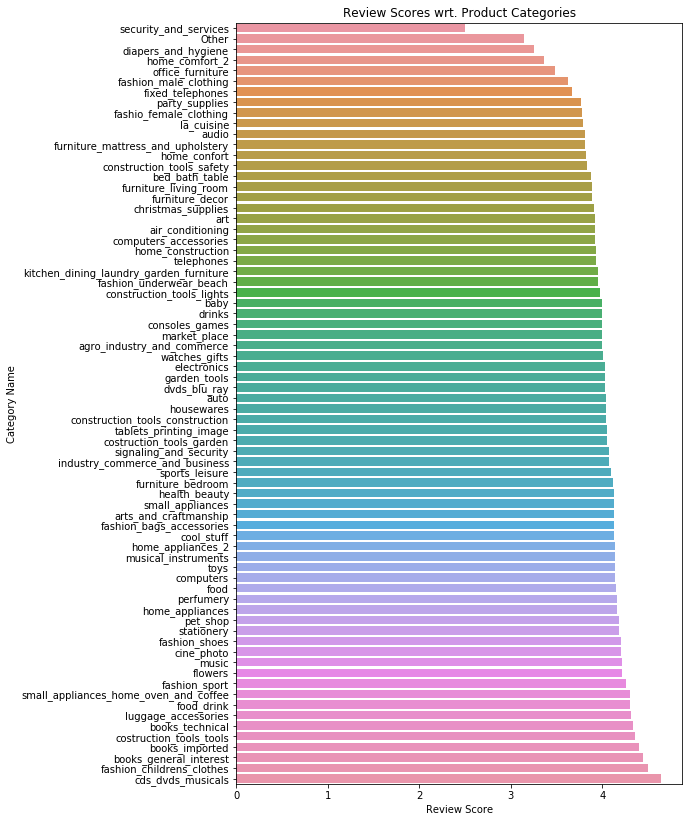

In [29]:
#Plot Review scores by product category
plt.figure(figsize = (8, 14))
ax = sns.barplot(all_data.groupby('product_category_name_english').mean()['review_score'].sort_values(), 
               all_data.groupby('product_category_name_english').mean()['review_score'].sort_values().index,
           )
plt.ylabel('Category Name')
plt.xlabel('Review Score')
plt.title('Review Scores wrt. Product Categories')
plt.show()

The barplot reveals that the first four product categories (security & services, diapers & hygiene, home comfort, and office furniture) yield review scores far below average. Children's clothes, musicals, and books yielded the highest review scores.

There is a weak correlation of about 30%, so larger items usually do not cost more based on their size alone.

In [30]:
all_data.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_installments', 'payment_value', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'product_name_length', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'geolocation_lat_customer',
       'geolocation_lng_customer', 'geolocation_lat_seller',
       'geolocation_lng_seller'],
      dtype='object')

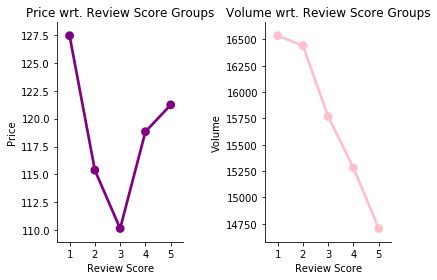

In [31]:
#Correlation of volume/price to satisfaction 
#First combine dimensions into volume
all_data['product_volume_cm']=all_data['product_height_cm']*all_data[
    'product_length_cm']*all_data[
    'product_width_cm']
fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True)
sns.pointplot(all_data.groupby('review_score').mean().index, 
                all_data.groupby('review_score').mean()['price'], 
             ax = ax1, color = 'purple', ci = 68)
ax1.set(title = 'Price wrt. Review Score Groups', 
        ylabel = 'Price', xlabel = 'Review Score')
sns.pointplot(all_data.groupby('review_score').mean().index, 
                all_data.groupby('review_score').mean()['product_volume_cm'], 
             ax = ax2, color = 'pink', ci = 68)
ax2.set(title = 'Volume wrt. Review Score Groups', 
        ylabel = 'Volume', xlabel = 'Review Score')
sns.despine(right=True, top=True, ax=ax1)
sns.despine(right=True, top=True, ax=ax2)
plt.tight_layout()
plt.show()

Price has an interesting relationship with review scores: high prices appear to fetch the worst scores, while the lowest prices fetch average scores, and medium prices. This may be in part due to high customer expectations for expensive items, while items with average pricing are under less intense scrutiny. 

The product volume has a clear negative correlation with review scores, as the largest products are associated with the worst scores. The delivery process may take longer for larger/heavier products, which would result in more negative review scores.

In [32]:
#Do products that travel farther induce lower review scores?
#Calculate Vincenty distance using geolocation coordinates
coords1 = all_data[['geolocation_lat_customer', 'geolocation_lng_customer']]
coords2 = all_data[['geolocation_lat_seller', 'geolocation_lng_seller']]
cust_seller_distances = [geopy.distance.distance(
    coords1.iloc[i], coords2.iloc[i]).km for i in all_data.index]
all_data['customer_to_seller_distance_km'] = pd.Series(cust_seller_distances)

#Create variable to express time between order and delivery
all_data['days_to_delivery'] = (all_data.order_delivered_customer_date-\
all_data.order_delivered_carrier_date).dt.days

#Bool for timeliness
all_data['is_on_time'] = all_data.order_estimated_delivery_date>= \
all_data.order_delivered_customer_date


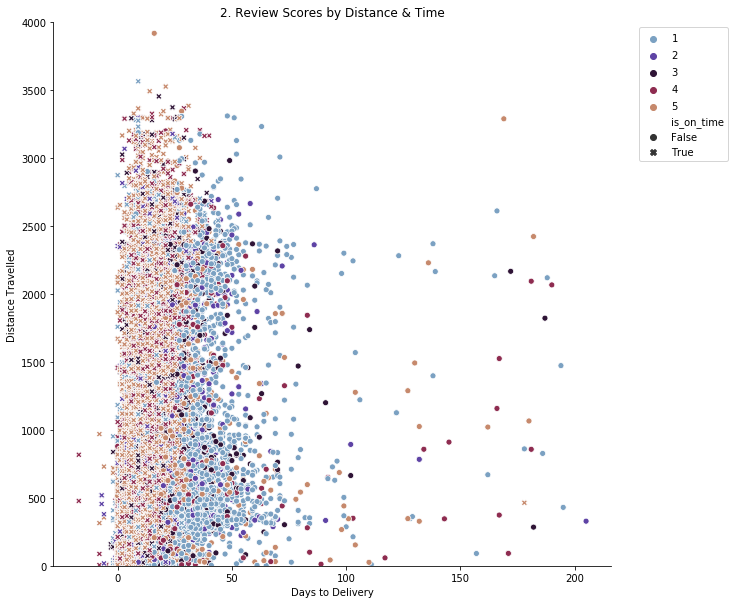

In [33]:
#To what degree does distance affect delivery time?
#Small workaround to present hues correctly
string_reviews =  ["$%s$" % x for x in all_data.review_score]
fig, ax1 = plt.subplots(figsize = (10, 10))
sns.scatterplot(x = 'days_to_delivery', y = 'customer_to_seller_distance_km', 
               data = all_data, hue = string_reviews, style='is_on_time', 
                hue_order = ['$1$', '$2$', '$3$', '$4$', '$5$'],
               palette = 'twilight', ax = ax1)
ax1.set(title = '2. Review Scores by Distance & Time',
        ylabel = 'Distance Travelled', xlabel = 'Days to Delivery')
ax1.legend(bbox_to_anchor = (1.04, 1), loc = 'upper left')
sns.despine(right=True, top=True, ax=ax1)
plt.ylim(0, 4000)
plt.show()

Figure 1 shows that most packages are expected to arrive within 30 days, while the bottom displays how timeliness affects review scores. Most of the top reviews come in the same range as the on-time group, while the highest concentration of low scores come 30 days after the product has been marked on the way.

Text(0.5, 1.0, 'Distances wrt. Review Scores')

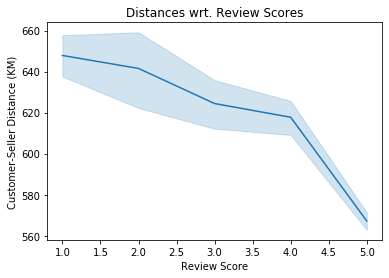

In [34]:
#Plot distance and review scores
sns.lineplot(y = 'customer_to_seller_distance_km', x = 'review_score', data = all_data)
plt.xlabel('Review Score')
plt.ylabel('Customer-Seller Distance (KM)')
plt.title('Distances wrt. Review Scores')

Review scores are much higher on average when the product travels less distance. 

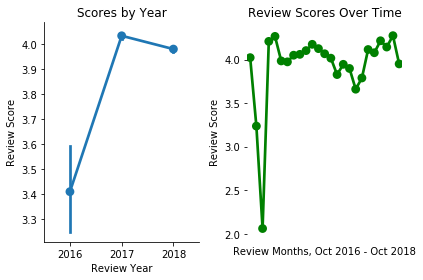

In [35]:
#How do review scores differ by time of year?
f, (ax1, ax2,) = plt.subplots(1, 2)
sns.pointplot(all_data.review_answer_timestamp.dt.year,
              all_data.review_score, ax = ax1)
ax1.set(title = 'Scores by Year', 
        ylabel = 'Review Score', xlabel = 'Review Year')
sns.despine(right=True, top=True, ax=ax1)
grouped_months =  all_data.groupby(pd.Grouper(
    key = 'review_answer_timestamp', freq = 'M')).mean()
sns.pointplot(grouped_months.index, 
              grouped_months['review_score'],
              color = 'green', ax = ax2)
ax2.set(title = 'Review Scores Over Time', xticks = [],
       ylabel = 'Review Score', xlabel = 'Review Months, Oct 2016 - Oct 2018')
# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()

Averages appear to have improved from 2016 to 2017, but the lack of data from 2016 (375 reviews) signifies this difference may be due to sampling error rather than a significant improvement in service. By month, reviews succeed most in July through September and dip annually from December until March. 

In [36]:
#Do angrier customers review faster?
time_until_review = all_data.review_answer_timestamp-all_data.review_creation_date
#Round up a day if over 12 hours
days_until_review = time_until_review.dt.round('1d').dt.days
all_data['days_until_review'] = pd.Series(days_until_review)

Low Reviewers waiting 20 days or more to review: 17.89%
High Reviewers waiting 20 days or more to review: 74.98%


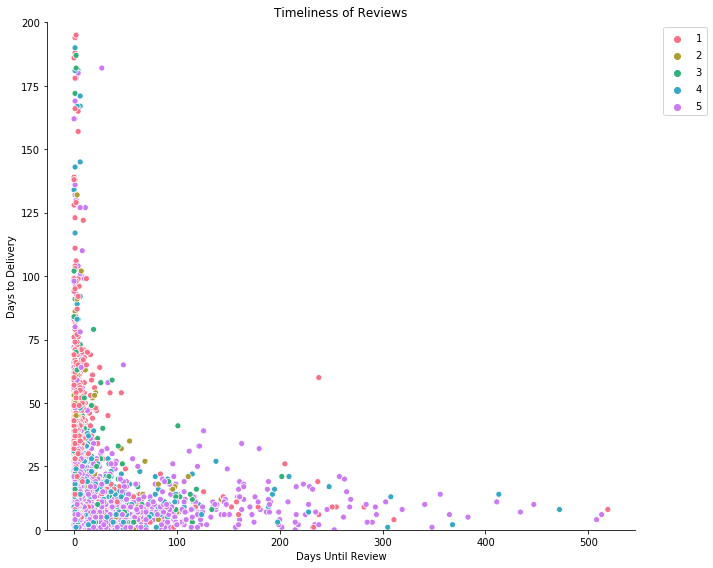

In [37]:
#What effect does waiting to review have on scores?
fig, ax1 = plt.subplots(figsize = (10, 8))

sns.scatterplot(x = 'days_until_review', 
            y = 'days_to_delivery', 
                data = all_data, hue = string_reviews,
                hue_order = ['$1$', '$2$', '$3$', '$4$', '$5$'], 
                palette = 'husl', ax = ax1)
ax1.set(title = 'Timeliness of Reviews', ylabel = 'Days to Delivery', 
        xlabel = 'Days Until Review', ylim = (0, 200))
ax1.legend(bbox_to_anchor = (1.04, 1), loc = 'upper left')
print('Low Reviewers waiting 20 days or more to review: {:.2f}%'.format(100*
    all_data[
        (all_data.review_score<=2)&(all_data.days_until_review>=20)
    ].shape[0]/all_data[all_data.days_until_review>=20]['review_score'].shape[0]
)
     )
print('High Reviewers waiting 20 days or more to review: {:.2f}%'.format(100*
    all_data[
        (all_data.review_score>=4)&(all_data.days_until_review>=20)
            ].shape[0]/all_data[all_data.days_until_review>=20]['review_score'].shape[0]
)
     )
sns.despine(right=True, top=True, ax=ax1)
plt.tight_layout()
plt.show()

Less satisfied customers are very quick to provide their reviews-- A majority of the reviews under 3 came within 20 days, while most of the above average reviewers underwent a long deliberation phase of at least 3 weeks before providing their feedback. 

# RFM Approach

Here we will rank each customer based on their Recency, Frequency, and Monetary contributions to the site. By segmenting customers based on their value and evaluating which customer service issues are most frequent/severe for the most valuable customer segments, OList may make more efficient decisions regarding operational solutions. 


## Recency

To calculate the recency score of each customer, the days inactive will be calculated by subtracting the last date active from the most recent date.   

In [38]:
df_recency = all_data.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_recency.columns = ['customer_unique_id', 'newest_purchase']
df_recency['Recency'] = (df_recency['newest_purchase'].max()-df_recency['newest_purchase']).dt.days

## Frequency 

Frequency may be calculated by counting repeat visits by unique customer IDs. 

In [39]:
#
df_frequency = all_data.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id', 'Frequency']
df_frequency.Frequency.describe()

count    96096.000000
mean         1.187354
std          0.651174
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         24.000000
Name: Frequency, dtype: float64

## Monetary

The sum of all purchases per person will represent the monetary worth of each customer.

In [40]:
df_monetary = all_data.groupby('customer_unique_id').payment_value.sum().reset_index()
df_monetary.columns = ['customer_unique_id', 'Monetary']

In [41]:
#Merge all measurements
df_rfm = pd.merge(df_recency, df_frequency, on = 'customer_unique_id').merge(
    df_monetary, on = 'customer_unique_id').drop(columns = 'newest_purchase')

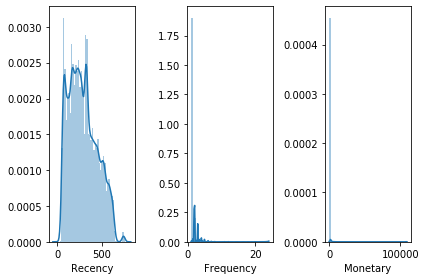

In [42]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)

sns.distplot(df_rfm.Recency, ax = ax1)
sns.distplot(df_rfm.Frequency, ax = ax2)
sns.distplot(df_rfm.Monetary, ax = ax3)

plt.tight_layout()

Recency resembles a normal distribution, while Frequency and Monetary have strong right skews. Rather than scale the variables, quartiles will be calculated upon each variable so each customer receives a 1-4 score. 


In [43]:
# Assign scores based on 4 most equal quintile bins possible
df_rfm['R_Score'] = pd.qcut(df_rfm.Recency, q = 4, labels = [4, 3, 2, 1])
df_rfm['F_Score'] = pd.cut(df_rfm.Frequency,bins = [0, 1, 2, 9, 24], 
                         labels = [1, 2, 3, 4])
df_rfm['M_Score'] = pd.qcut(df_rfm.Monetary, q = 4, labels = [1, 2, 3, 4])
df_rfm['RFM_Label'] = df_rfm.R_Score.astype(str).str.cat(
    df_rfm.F_Score.astype(str).str.slice(stop = 1)).str.cat(
    df_rfm.M_Score.astype(str))
df_rfm['RFM_Score'] = df_rfm.apply(lambda row: row.R_Score + row.F_Score+row.M_Score, axis = 1)
df_rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Label,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,4,1,3,413,8
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,4,1,1,411,6
2,0000f46a3911fa3c0805444483337064,585,1,86.22,1,1,2,112,4
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,2,1,1,211,4
4,0004aac84e0df4da2b147fca70cf8255,336,1,196.89,2,1,3,213,6


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

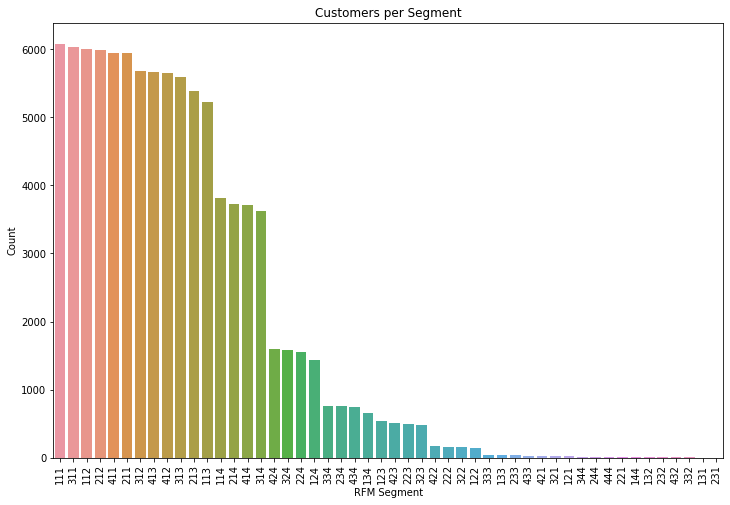

In [44]:
plt.figure(figsize = (12, 8))
sns.barplot(df_rfm.RFM_Label.value_counts().index, df_rfm.RFM_Label.value_counts(), 
           order = df_rfm.RFM_Label.value_counts().index)
plt.ylabel('Count')
plt.xlabel('RFM Segment')
plt.title('Customers per Segment')
plt.xticks(rotation = 90)

Among the most common RFM segments, 4 of the top 6 all end with 1 values for Frequency and Monetary, indicating the majority of customers are infrequent and low spenders.

The 111 segment contains the most customers, which have long since left the platform and spent little during their transactions. Many of the segments containing the highest spending customers have only visited the platform once, while only 3138 customers have visited more than twice. 

## RFM Cluster Evaluation and Selection

The optimal number of clusters should be chosen where the reduction of inertia introduced by adding a cluster decreases sharply, which will indicate the centroids of the clusters are reasonably close to their terminal position.  

After the optimal number of clusters is specified, the algorithms producing the highest silhouette scores will be visualized to determine which solution algorithm produces the most separate and dense clusters.

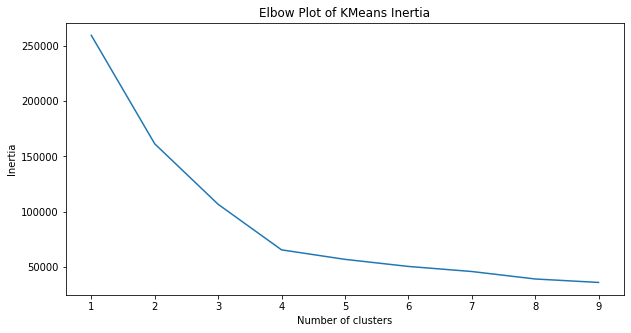

In [45]:
rfm = df_rfm[['R_Score', 'F_Score', 'M_Score']]
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(rfm)
    sse[k] = kmeans.inertia_
    
plt.figure(figsize = (10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('Elbow Plot of KMeans Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

The elbow's slope changes sharply at 4 clusters, so the ideal number of clusters will be 4. 

In [46]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by = target_field_name,ascending = ascending
                               ).reset_index(drop = True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']],
                        on = cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis = 1)
    df_final = df_final.rename(columns = {"index":cluster_field_name})
    return df_final

#
df_rfm.R_Score = df_rfm.R_Score.astype(int)
df_rfm.F_Score = df_rfm.F_Score.astype(int)
df_rfm.M_Score = df_rfm.M_Score.astype(int)

In [47]:
#Take sample to check score for Agglomerative Clustering
rfm_sample = rfm.sample(frac = 0.1)
KMeans_Cluster = KMeans(n_clusters = 4).fit_predict(rfm_sample)
print('Silhouette Score of KMeans solution: {:.2f}'.format(
    metrics.silhouette_score(
        rfm_sample, 
        KMeans_Cluster, metric = 'euclidean'
    )
)
     )
agg =  AgglomerativeClustering(linkage =  'ward', n_clusters = 4)
agg_clusters = agg.fit_predict(rfm_sample)
print('Silhouette Score of Ward linkage and Euclidean distance: {:.2f}'.format(
    metrics.silhouette_score(
    rfm_sample,agg_clusters, metric = 'euclidean')
)
     )
gmm_cluster = GaussianMixture(n_components = 4).fit_predict(rfm_sample)
print('Silhouette Score of EM solution: {:.2f}'.format(
    metrics.silhouette_score(
    rfm_sample,gmm_cluster,)
)
     )

Silhouette Score of KMeans solution: 0.48
Silhouette Score of Ward linkage and Euclidean distance: 0.44
Silhouette Score of EM solution: 0.30


In [48]:
#Testing Agglomerative Clustering
# Check parameter combinations
linkages = ['complete', 'average']
affinities = ['l2', 'l1', 'cosine']
#Loop through combinations
for link in linkages:
    for dist in affinities:
        agg =  AgglomerativeClustering(linkage =  link, 
                                     affinity = dist, 
                                     n_clusters = 4).fit_predict(rfm_sample)
        print('Silhouette score of cluster method with \
{0} linkage type and {1} distance: {2:.2f}'.format(
            link, dist, metrics.silhouette_score(
    rfm_sample,agg)
             )
             )

Silhouette score of cluster method with complete linkage type and l2 distance: 0.35
Silhouette score of cluster method with complete linkage type and l1 distance: 0.31
Silhouette score of cluster method with complete linkage type and cosine distance: 0.24
Silhouette score of cluster method with average linkage type and l2 distance: 0.38
Silhouette score of cluster method with average linkage type and l1 distance: 0.32
Silhouette score of cluster method with average linkage type and cosine distance: 0.27


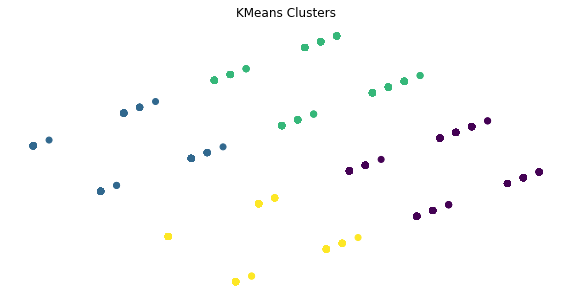

In [49]:
#Plot best KMeans solution using PCA
pca_results=PCA(n_components = 2).fit_transform(
    df_rfm[['R_Score', 'F_Score', 'M_Score']].loc[rfm_sample.index]
)
KMeans_Cluster = KMeans(n_clusters = 4).fit_predict(rfm_sample)
plt.figure(figsize = (10,5))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c = KMeans_Cluster)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('KMeans Clusters')
plt.show()

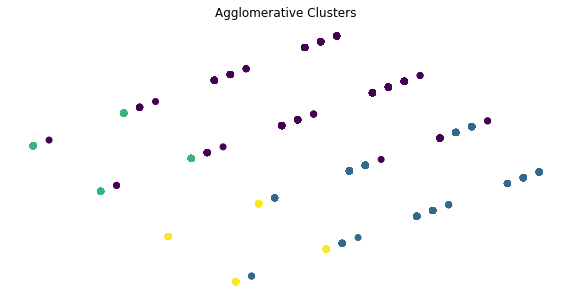

In [50]:
#Plot best Agglomerative solution using PCA
plt.figure(figsize = (10,5))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c = agg_clusters)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.title('Agglomerative Clusters')
plt.show()

KMeans shows superior separation of clusters and had the highest silhouette score, making it the final choice. 

In [51]:
#Add best solution to dataframe, inspect results
KMeans_Cluster=KMeans(n_clusters = 4, random_state=49).fit_predict(df_rfm[['R_Score', 'F_Score', 'M_Score']])
df_rfm['RFM_Cluster'] = pd.Series(KMeans_Cluster)
df_rfm = order_cluster('RFM_Cluster', 'RFM_Score', df_rfm, True)
pd.concat([df_rfm.groupby('RFM_Cluster').mean(), 
           df_rfm.RFM_Cluster.value_counts().sort_index().rename('Size')], axis=1)

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Size
0,414.784313,1.014653,65.288388,1.497045,1.014489,1.505213,4.016746,24364
1,161.196487,1.016128,64.950141,3.497594,1.016085,1.492401,6.006080,23686
2,414.516507,1.352877,364.378132,1.505432,1.298305,3.505305,6.309042,23657
3,160.733404,1.365616,362.135154,3.503424,1.304195,3.494813,8.302431,24389


Cluster 0 is categorized by customers who shopped once on the site, spent very little, and did not return for future purchases. 

Cluster 1 contains more recent customers that visited recently and more frequently spending small amounts each time. 

Cluster 2 contains high value customers, who visited multiple times but have since stopped purchasing items.

Cluster 3 is the highest value cluster comprised of customers who visited recently and frequently while spending heavily on purchases. 

In [52]:
clustdict={0: 'Churned, Low', 1:'Active, Low', 2: 'Churned, High', 3:'Active, High'}
df_rfm.RFM_Cluster=df_rfm.RFM_Cluster.map(clustdict)

In [53]:
#Inspect group differences
all_data = pd.merge(all_data, 
                  df_rfm[['customer_unique_id', 'RFM_Cluster']],
                  on = 'customer_unique_id')
grouped_rfm = all_data.groupby('RFM_Cluster').mean()
grouped_rfm

,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,seller_zip_code_prefix,product_name_length,...,product_width_cm,geolocation_lat_customer,geolocation_lng_customer,geolocation_lat_seller,geolocation_lng_seller,product_volume_cm,customer_to_seller_distance_km,days_to_delivery,is_on_time,days_until_review
RFM_Cluster,,,,,,,,,,,,,,,,,,,,,
"Active, High",35834.181739,3.896745,1.094788,3.633940,265.180876,1.341702,171.957969,24.315273,26901.343031,49.187632,...,23.898591,-22.669220,-47.179152,-21.107917,-46.202688,18212.147101,626.967958,8.858374,0.905723,2.985138
"Active, Low",31371.845604,4.152360,1.113470,1.979973,63.919272,1.007587,48.494964,15.298496,20517.785981,48.699136,...,20.137456,-22.856478,-47.241132,-21.755463,-46.304929,8247.358514,497.393590,7.980347,0.903233,2.887901
"Churned, High",37474.148914,3.894766,1.192439,3.968224,269.335837,1.340908,175.754013,22.659402,26736.805374,48.607088,...,25.707859,-22.816231,-47.267121,-20.850264,-46.076547,21551.351754,661.109308,9.262428,0.933729,3.466490
"Churned, Low",34693.365843,4.126168,1.173577,2.216132,64.345548,1.006591,49.654279,15.226495,21967.665790,48.521670,...,21.087379,-22.893179,-47.277706,-21.414297,-46.273336,9732.204293,561.221219,8.661421,0.940172,3.500506


In [54]:
#Sort variables by variance between RFM Clusters
(grouped_rfm.std()/grouped_rfm.mean()).sort_values(ascending=False)

payment_value                     0.707848
price                             0.646486
product_weight_g                  0.604989
product_volume_cm                 0.447710
payment_installments              0.338131
freight_value                     0.247567
product_height_cm                 0.222043
order_item_id                     0.164334
seller_zip_code_prefix            0.136248
product_description_length        0.128741
customer_to_seller_distance_km    0.123634
product_width_cm                  0.112708
product_length_cm                 0.111962
days_until_review                 0.099248
customer_zip_code_prefix          0.074059
days_to_delivery                  0.061624
payment_sequential                0.040936
review_score                      0.035096
product_photos_qty                0.032526
is_on_time                        0.020592
product_name_length               0.006115
geolocation_lng_customer         -0.000935
geolocation_lng_seller           -0.002193
geolocation

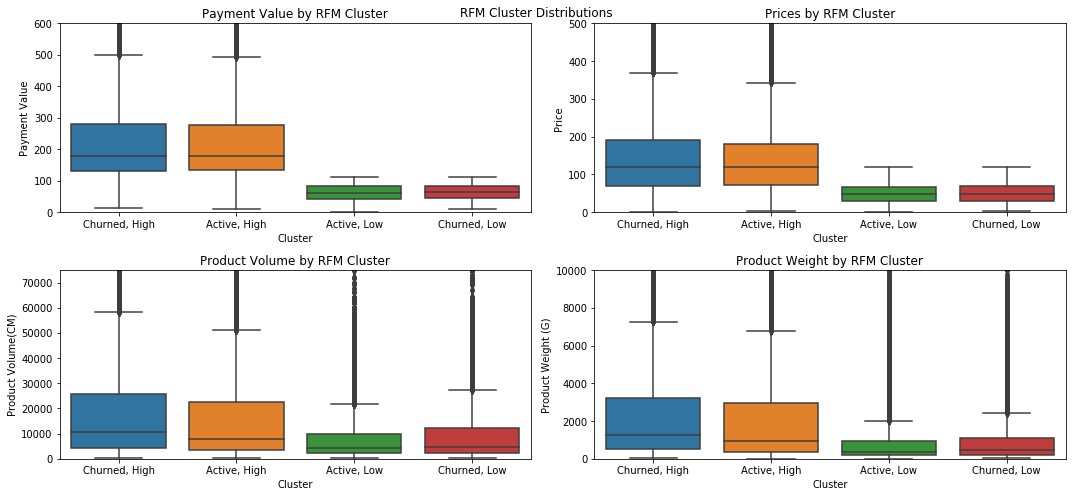

In [55]:
#Plot boxplots of variables with highest variances between clusters
fig, axes = plt.subplots(2, 2, figsize = (15, 7))
sns.boxplot(x = 'RFM_Cluster', y = 'payment_value', 
            data = all_data, ax = axes[0, 0])
sns.boxplot(x = 'RFM_Cluster', y = 'price', 
            data = all_data, ax = axes[0, 1])
sns.boxplot(x = 'RFM_Cluster', y = 'product_volume_cm', 
            data = all_data, ax = axes[1, 0])
sns.boxplot(x = 'RFM_Cluster', y = 'product_weight_g',
            data = all_data, ax = axes[1, 1])
axes[0, 0].set(title = 'Payment Value by RFM Cluster', ylim = (0, 600),
               ylabel = 'Payment Value', xlabel='Cluster')
axes[0, 1].set(title = 'Prices by RFM Cluster', ylabel = 'Price',
               ylim = (0, 500), xlabel='Cluster')
axes[1, 0].set(title = 'Product Volume by RFM Cluster', ylabel = 'Product Volume(CM)', 
               ylim = (0, 75000), xlabel='Cluster')
axes[1, 1].set(title = 'Product Weight by RFM Cluster', ylabel = 'Product Weight (G)',
               ylim = (0, 10000), xlabel='Cluster')
plt.suptitle('RFM Cluster Distributions')
plt.tight_layout()

Payment Value shows the highest variance between clusters, as it is consists of the price combined with taxes and shipping fees. There is a clear divide between high and low value customers here, with many customers paying far more than the 75th percentile. By volume and weight measures, low value clusters had a much denser interquartile range, indicating a much smaller standard deviation from the mean. While high value customers vary greatly in the size and weight of products they purchase, low value customers have a much higher probability of purchasing smaller, lighter products with few exceptions.

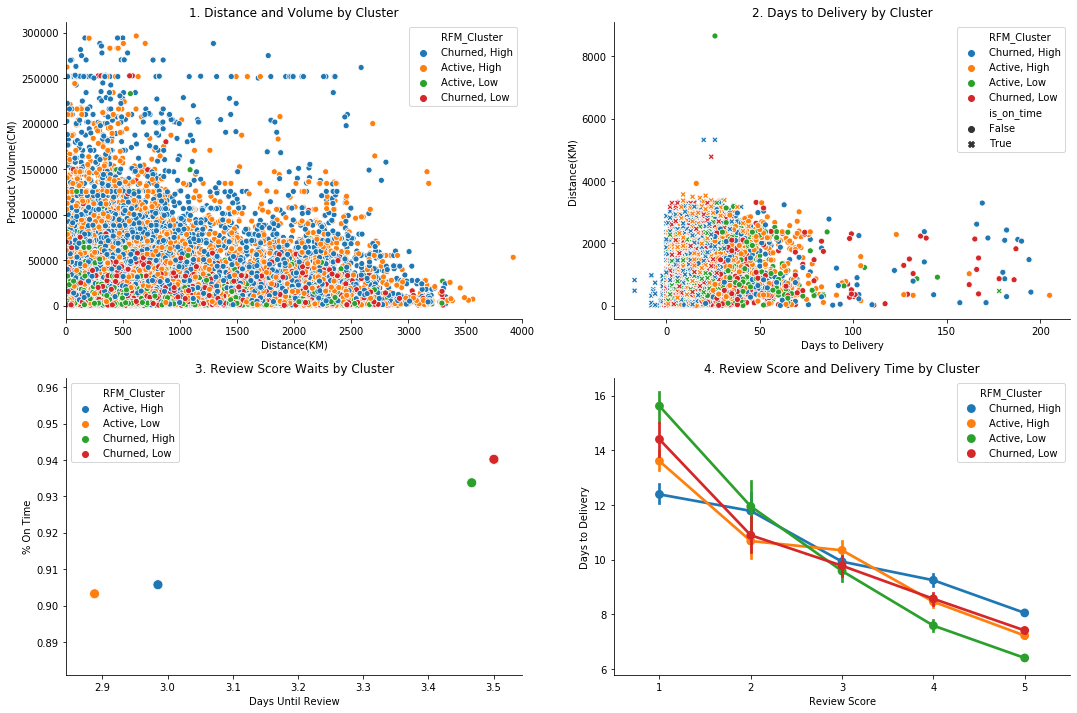

In [56]:
#Plot mean differences by cluster
grouped_rfm = all_data.groupby('RFM_Cluster').mean()

f, axes = plt.subplots(2, 2, figsize = (18, 12))
sns.scatterplot(x = 'customer_to_seller_distance_km', y = 'product_volume_cm',
                hue='RFM_Cluster', data=all_data, ax = axes[0,0])
sns.scatterplot(x = 'days_to_delivery', y = 'customer_to_seller_distance_km',
                hue = 'RFM_Cluster', style='is_on_time',
              data = all_data, ax = axes[0,1])
sns.scatterplot(x = 'days_until_review', y='is_on_time', hue=grouped_rfm.index,       
            data = grouped_rfm, s=100, ax = axes[1, 0])
sns.pointplot(x =  'review_score', 
              y = 'days_to_delivery',
                hue = 'RFM_Cluster',
                data = all_data, ax = axes[1, 1])
axes[0, 0].set(title = '1. Distance and Volume by Cluster',
               xlabel = 'Distance(KM)', ylabel = 'Product Volume(CM)',
              xlim=(0, 4000))
axes[0, 1].set(title = '2. Days to Delivery by Cluster', 
               xlabel = 'Days to Delivery', ylabel = 'Distance(KM)')
axes[1, 0].set(title = '3. Review Score Waits by Cluster', 
               xlabel = 'Days Until Review', ylabel = '% On Time')
axes[1, 1].set(title = '4. Review Score and Delivery Time by Cluster', 
               xlabel = 'Review Score', ylabel = 'Days to Delivery')
sns.despine(right=True, top=True, ax=axes[0, 0])
sns.despine(right=True, top=True, ax=axes[0, 1])
sns.despine(right=True, top=True, ax=axes[1, 0])
sns.despine(right=True, top=True, ax=axes[1, 1])

## Comments 

1. Most of the high value customers buy larger products, while customers in low value clusters tend to purchase smaller goods. 

2. In the packages travelling further tended to be late, and the Low Churned group tends to have many packages travelling farther than usual. The Active Low group has many less instances of packages travelling more than 50 kilometers. Additionally, errors in tracking delivery times (where days to delivery is less than 0) may have cost valuable business, as it is comprised of 46 High Churn and 4 Low Churn customers. 

3. The churned groups received their packages on time 3-4% more often, but waited much longer to submit their reviews, which could be in part due to longer estimates for delivery times.

4. Fewer days to delivery resulted in higher review scores across all groups, but the churned groups waited longer for most of their deliveries when providing positive reviews. 

# Frequency Segments

By segmenting customers based on frequency alone, trends of more frequent users may be isolated and analyzed to determine which types of items frequent users typically purchase and what factors may be influencing them to return. 

As frequency is a 1 dimensional array, the Jenks Natural Breaks Optimization can sort the data to minimize variance within each group and maximize variance between groups. 

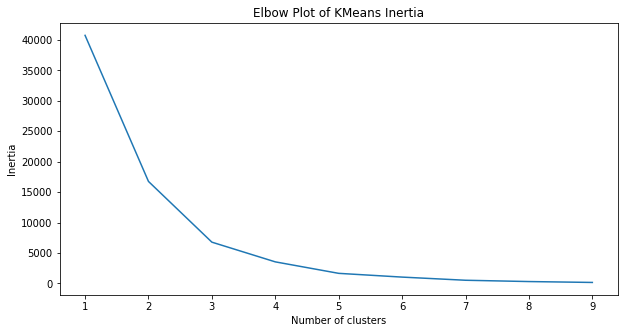

In [57]:
#Determine optimal number of clusters
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(df_rfm[['Frequency']])
    sse[k] = kmeans.inertia_
    
plt.figure(figsize = (10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('Elbow Plot of KMeans Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Here, the elbow plot has a more gradual descent, and the inertia approaches 0 rapidly after the 5 cluster solution.

In [58]:
#Split Frequency into 5 segments 
breaks = jenkspy.jenks_breaks(df_rfm.Frequency, nb_class=5)
breaks

[1.0, 1.0, 2.0, 4.0, 9.0, 24.0]

Text(0.5, 1.0, 'Frequency Break Points')

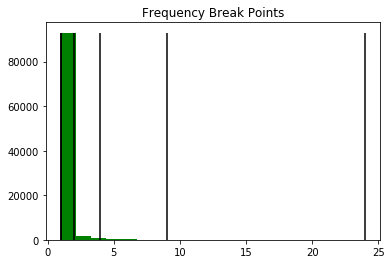

In [59]:
#Plot segments across histogram
hist = plt.hist(df_rfm.Frequency, bins=20, color='g')
for b in breaks:
    plt.vlines(b, ymin=0, ymax = max(hist[0]))
plt.title('Frequency Break Points')

Since 88% buyers are one-time visitors, converting even 1% into repeat customers would lead to 8407 new customers, generating $630525 in new revenue on their 2nd visit. 

In [60]:
K_freq_clusters=pd.cut(df_rfm.Frequency,bins = [0, 1, 2, 4, 9, 24], 
                         labels = [1, 2, 3, 4, 5])
df_rfm['Frequency_Cluster'] = pd.Series(K_freq_clusters)
df_rfm = order_cluster('Frequency_Cluster', 'Frequency', df_rfm, True)
df_rfm.groupby('Frequency_Cluster').mean()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
Frequency_Cluster,,,,,,,
0,288.328528,1.000000,152.480063,2.496806,1.0,2.328385,5.825192
1,283.616571,2.000000,390.937699,2.533041,2.0,3.608128,8.141169
2,285.105982,3.281012,889.569201,2.517864,3.0,3.928543,9.446407
3,278.494966,5.760067,2609.901040,2.598993,3.0,3.996644,9.595638
4,264.313725,12.803922,10145.574314,2.666667,4.0,4.000000,10.666667


In [61]:
#Merge frequency clusters
all_data = pd.merge(all_data, 
                  df_rfm[['customer_unique_id', 'Frequency_Cluster']],
                  on = 'customer_unique_id')

In [62]:
grouped_freq = all_data.groupby('Frequency_Cluster').mean()
grouped_freq

,customer_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,seller_zip_code_prefix,product_name_length,...,product_width_cm,geolocation_lat_customer,geolocation_lng_customer,geolocation_lat_seller,geolocation_lng_seller,product_volume_cm,customer_to_seller_distance_km,days_to_delivery,is_on_time,days_until_review
Frequency_Cluster,,,,,,,,,,,,,,,,,,,,,
0,35277.001641,4.122736,1.135879,2.892061,152.480063,1.000000,131.458615,20.436271,24723.766589,48.874663,...,22.999994,-22.788366,-47.198000,-21.132119,-46.151959,15241.995413,606.600253,9.008718,0.916170,3.225442
1,34457.100191,3.737026,1.157042,3.397445,195.468849,1.390685,93.900801,18.794393,24079.302882,48.577221,...,23.124355,-22.796843,-47.327640,-21.522304,-46.293068,14994.454291,561.841928,8.186198,0.929979,3.185298
2,34802.947510,3.597577,1.235409,3.809862,271.126499,1.846126,85.403475,18.602478,22916.763857,48.751792,...,23.057275,-22.856265,-47.406123,-21.416049,-46.328184,14920.576489,571.066709,7.964395,0.937110,3.082711
3,34330.279348,3.504515,1.058258,3.800175,453.102540,2.791132,80.963046,18.571919,23403.474803,47.813667,...,22.433737,-22.943862,-47.378289,-21.691761,-46.577838,16042.118586,542.393456,7.296825,0.932129,3.348966
4,38570.560490,2.961715,1.000000,4.258806,792.380230,4.917178,77.099650,18.071868,22183.637060,47.098346,...,22.514554,-22.657571,-47.151856,-22.629454,-46.992736,16127.606771,574.045944,7.173047,0.954058,2.984686


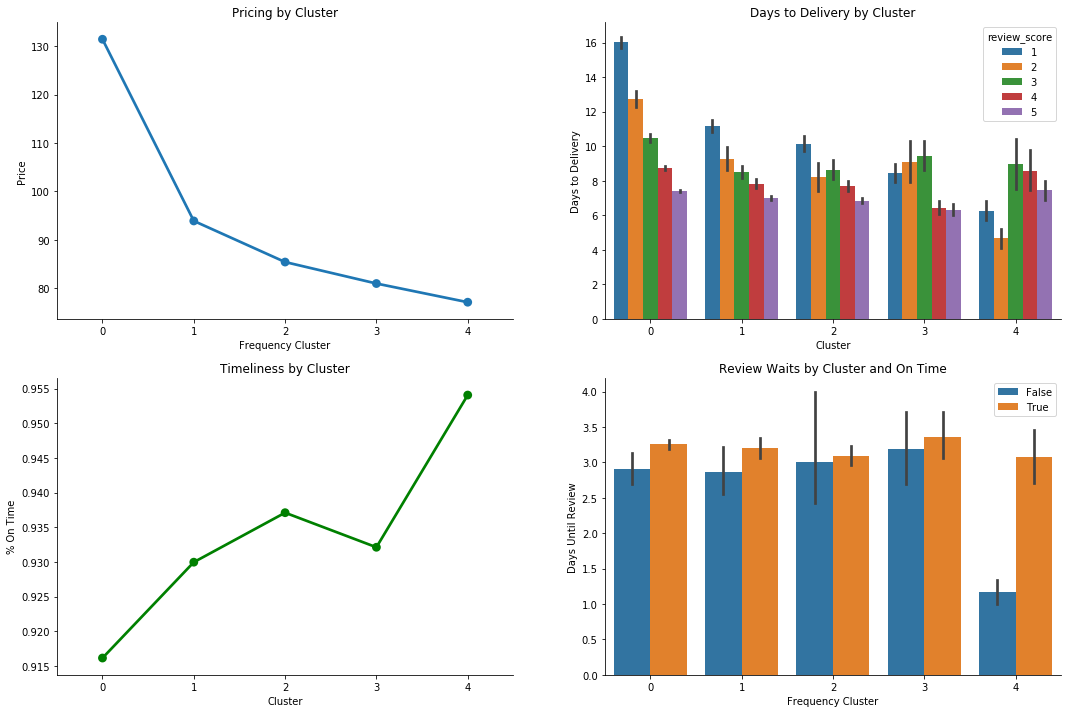

In [63]:
f, axes = plt.subplots(2, 2, figsize = (18, 12))
sns.pointplot(x=grouped_freq.index, y='price',
            data=grouped_freq, ax = axes[0,0])
sns.barplot(x='Frequency_Cluster', y='days_to_delivery',
            hue='review_score', data=all_data, ax = axes[0,1])
sns.pointplot(x = grouped_freq.index, y = 'is_on_time', color = 'green',
            data = grouped_freq, ax = axes[1, 0])
sns.barplot(x='Frequency_Cluster', y='days_until_review',
            hue='is_on_time', data=all_data, ax = axes[1, 1])
axes[0, 0].set(title = 'Pricing by Cluster',
               xlabel = 'Frequency Cluster', ylabel = 'Price')
axes[0, 1].set(title = 'Days to Delivery by Cluster', 
               xlabel = 'Cluster', ylabel = 'Days to Delivery')
axes[1, 0].set(title = 'Timeliness by Cluster', xlabel = 'Cluster',
               ylabel = '% On Time')
axes[1, 1].set(title = 'Review Waits by Cluster and On Time', 
               xlabel = 'Frequency Cluster', ylabel = 'Days Until Review')
axes[1, 1].legend(loc='upper right')
sns.despine(right=True, top=True, ax=axes[0, 0])
sns.despine(right=True, top=True, ax=axes[0, 1])
sns.despine(right=True, top=True, ax=axes[1, 0])
sns.despine(right=True, top=True, ax=axes[1, 1])

## Comments

The most frequent customers paid the lowest prices for products, and faster delivery times led to higher review scores in every group but the highest frequency customers. Since the range of that cluster's days to delivery is much smaller, this difference is less pronounced. 

The most frequent customers also have the fastest deliveries on average, with up to 96% on time. 

Lastly, packages with late deliveries were reviewed more quickly by every group, especially quickly in the most active cluster. 

Text(0.5, 0.98, 'Top 5 Product Categories by Cluster')

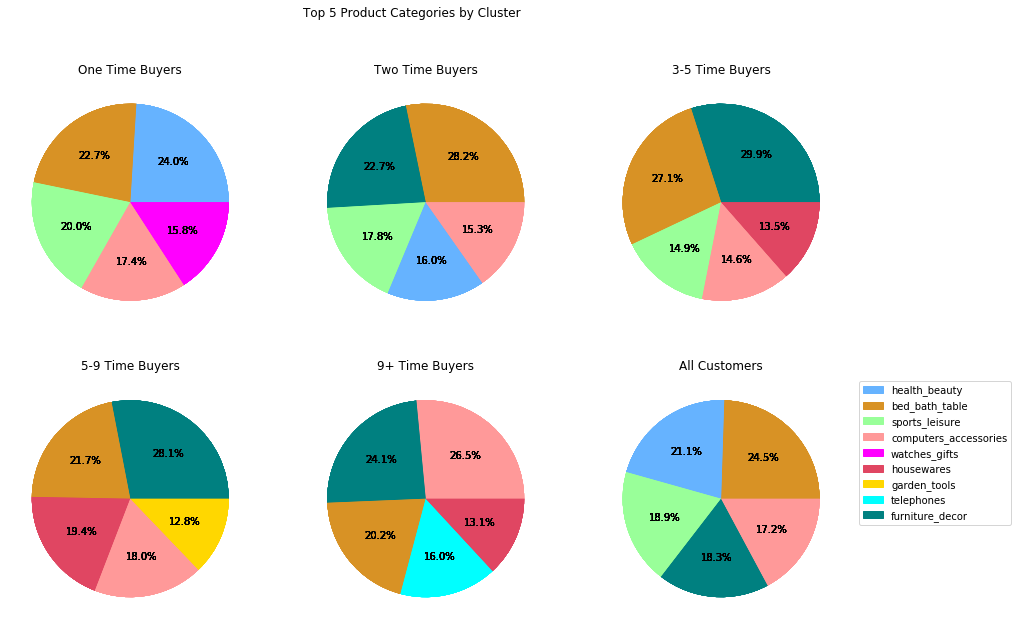

In [64]:
#Discover top 5 most common categories among freq customers
f, axes = plt.subplots(2, 3, figsize = (15, 10))

piedict = {'health_beauty':'#66b3ff', 'bed_bath_table':'#d89225', 'sports_leisure':'#99ff99',
        'computers_accessories':'#ff9999', 'watches_gifts':'#ff00ff', 'housewares':'#e04662', 
        'garden_tools':'#ffd700', 'telephones':'cyan', 'furniture_decor':'teal'}
for prod in list(piedict.keys()):    
    axes[0, 0].pie(all_data[all_data.Frequency_Cluster == 0]\
                   ['product_category_name_english'].value_counts()[:5], 
                  autopct = '%1.1f%%',
                   colors = [piedict[v] for v in 
                           all_data[all_data.Frequency_Cluster == 0]\
                   ['product_category_name_english'].value_counts()[:5].index])
    axes[0, 1].pie(all_data[all_data.Frequency_Cluster == 1]\
                   ['product_category_name_english'].value_counts()[:5], 
                   autopct = '%1.1f%%', 
                   colors = [piedict[v] for v in 
                           all_data[all_data.Frequency_Cluster == 1]\
                   ['product_category_name_english'].value_counts()[:5].index])
    axes[0, 2].pie(all_data[all_data.Frequency_Cluster == 2]\
                   ['product_category_name_english'].value_counts()[:5],  
                   autopct = '%1.1f%%', 
                   colors = [piedict[v] for v in 
                           all_data[all_data.Frequency_Cluster == 2]\
                   ['product_category_name_english'].value_counts()[:5].index])
    axes[1, 0].pie(all_data[all_data.Frequency_Cluster == 3]\
                   ['product_category_name_english'].value_counts()[:5], 
                   autopct = '%1.1f%%', 
                   colors = [piedict[v] for v in
                           all_data[all_data.Frequency_Cluster == 3]\
                   ['product_category_name_english'].value_counts()[:5].index])
    axes[1, 1].pie(all_data[all_data.Frequency_Cluster == 4]\
                   ['product_category_name_english'].value_counts()[:5], 
                   autopct = '%1.1f%%', 
                   colors = [piedict[v] for v in 
                           all_data[all_data.Frequency_Cluster == 4]\
                   ['product_category_name_english'].value_counts()[:5].index])
    axes[1, 2].pie(all_data['product_category_name_english'].value_counts()[:5], 
                   autopct = '%1.1f%%', 
                   colors = [piedict[v] for v in 
                           all_data['product_category_name_english'].\
                           value_counts()[:5].index])
axes[0, 0].set(title = 'One Time Buyers')
axes[0, 1].set(title = 'Two Time Buyers')
axes[0, 2].set(title = '3-5 Time Buyers')
axes[1, 0].set(title = '5-9 Time Buyers')
axes[1, 1].set(title = '9+ Time Buyers')
axes[1, 2].set(title = 'All Customers')

#Transform dictionary into working legend
patchList = []
for key in piedict:
        data_key = mpatches.Patch(color = piedict[key], label = key)
        patchList.append(data_key)

plt.legend(handles = patchList, bbox_to_anchor = (1.04, 1))
plt.suptitle('Top 5 Product Categories by Cluster')

## Comments

The purchasing habits of the most frequent customers differ greatly by product category. The one time customers bought many more sports related items and watches than any other group, while telephones and housewares were much more prevalent in the more frequent customers. 

Watches and health/beauty products are prevalent for one time buyers, but are no longer a popular segment in more frequent sections. Since these are the customers paying the highest prices, the intent of those buyers are more likely giftgiving while frequent buyers target product categories more suited for resale. Therefore, selling more products like watches and gifts may be beneficial to the bottom line, but will not help drive repeat business without creating a need to return for similar products. 


# Conclusion

When clustered by Recency, Frequency, and Monetary value, revealing differences between active high value members and churned high value members may help to explain what causes customer churn. The high and low value churned groups paid 2.39% and 2.31% more respectively for products. They also experienced more delays in deliveries (8.53% increase for high value, 4.56% for low) which may be in part due to the longer distances packages travelled and the bulk of the products.  

Although poor review scores may be an indicator of a customer's imminent departure, they alone do not predict the probability of additional purchases. The difference between churned and active group's review scores was only 0.008 points, and high value customers across both churned and active reported lower review scores than their respective low value counterparts by 0.11 points on average. 

The most frequent customers return for the low prices and delivery efficiency. Their reviews are lower on average, but price and speed are the driving forces behind their repeat business. Therefore, ensuring prices are competitive in the marketplace and optimizing delivery systems are essential in attracting customers back to the website. 

Product categories like bed/bath/table and computer accessories are quite popular across all frequency clusters. Sports/leisure and health/beauty products are highly popular in one time buyers, but are not purchased often more than 2 or 3 times, despite the fact that they need to be used and replaced constantly. By incorporating more sellers of sports/leisure equipment and health/beauty products, Olist will increase inventory options and quantities available of categories that only exist in the least frequent clusters to help drive traffic back to the site and continue to provide what people came for in the first place. 

# Considerations 

1. Since the distribution of customer frequency is so skewed, the mean differences per variable within the smallest frequency clusters may be prone to overfitting. 
2. The data is gathered over the course of a three year period, but there are only 375 instances of 2016 sales and reviews. Longitudinal inferences are effectively limited in their scope to changes between sales in 2017-2018. 
3. Since Olist is a logistics intermediary partner rather than a direct seller, improvements to quality control and inspection cannot be as tightly controlled. No data is available on the buyer's assessment of the incoming package's quality, so the correlation between low scores and product quality is unknown. 

# Proposed Improvements

Packages marked late were overwhelmingly correlated to low review scores and caused higher churn. Providing more realistic time estimates based on the size and weight of the package, as well as the distance it must travel between the seller and customer, will improve review scores by reframing customer expectations, which will foster more trust and dependability in repeat customers. 

Dissecting and finding a remedy for the deliveries with timestamp errors will help to reduce customer churn, as there could be a faulty scanner in the logisitics pipeline or issues communicating with sellers that is costing significant losses in terms of customers leaving permanently. 

Running an A/B test on the installation of auction price ceilings could determine whether keeping prices artificially low would entice enough customers into repeat business. Shaving profits off of one purchase could prove lucrative if they incentivize customers to flock back to the site in search of more deals. 



# Further Research

Analyzing competitors' pricing on their most frequently sold products would help determine whether Olist is offering the most competitive prices, and on which products 

Marketing data regarding the sales funnel would facilitate a more in-depth analysis on pinpointing the reasons behind customer churn. Repeat business is highly important to boosting profits, but finding out which points in the sales funnel have the largest reductions in traffic will explain why most visitors never become customers in the first place.

With more demographic information available, more descriptive clusters could determine which groups are underrepresented in the marketplace and where expansion may be possible. For example, the health and beauty products are a major category for one time buyers, but those customers do not return for additional purchases as often as those buying furniture decor or computer accessories. With demographics, future analysis could reveal the most underserved segments of customers, forging a path for more accurate email targeting and boosting sales in less popular domains.  